# Playing with $I$
----

Let's say we have the following function :
\begin{equation}
f^1_{a,b}(t) = a \cdot b \cdot t^2,
\end{equation}
with $a$ and $b$ two parameters. We want to find the values of $a$ and $b$ so that $f$ matches some experimental data. For the sake of this example, "experimental data" will be numerically generated using $\{a, b\} = \{2, 2\}$.

Solving this inverse problem is equivalent to solve the following equation:
\begin{equation}
a \cdot b \cdot t^2 = 4 \cdot t^2,
\end{equation}
which has an infinite number of solutions. The problem is therefore ill-posed.

Alternatively, if the function to minimize was for instance:
\begin{equation}
f^2_{a,b}(t) = a + (b/10) \cdot t^2,
\end{equation}

Then a unique solution could be found.

Another way to visualise this is to plot the cost function of the problem *e.g.* the function we were trying to minimize:
\begin{equation}
\Psi(a, b) = \sqrt{\frac{1}{T}\sum_{s=0}^T  (f_{a, b}(t_s) - f_{2,2}(t_s))^2}.
\end{equation}

Which could be done in python:

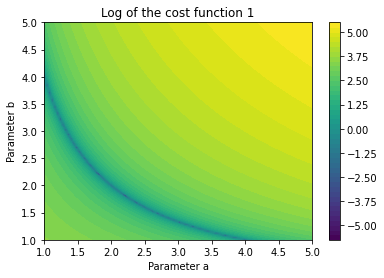

interactive(children=(FloatSlider(value=10.0, description='k', max=10.0, min=1.0, step=1.0), Output()), _dom_c…

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import math
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def test_fun(a, b, x, funNum,k):
    '''Basic test function with two parameters a and b'''
    if funNum == 1:
        return a * b * x**2
    else:
        return a + (b/k) * x**2
    
def plot_costFun(funNum=2, k=10.):
    a=2
    b=2
    T=100
    t = np.linspace(0,5,T)
    U = test_fun(a, b, t, funNum,k)
    a_grid = np.linspace(1.,5.,100)
    b_grid = np.linspace(1.,5.,100)
    A, B = np.meshgrid(a_grid, b_grid)
    costFun = np.zeros((100, 100))
    for i in range(0, 100):
        for j in range(0, 100):
            funVal = test_fun(A[i,j], B[i,j], t, funNum,k)
            costFun[i, j] = math.sqrt(np.sum((funVal - U)**2)/T)
    
    plt.contourf(A, B, np.log(costFun), 50)
    plt.xlabel("Parameter a")
    plt.ylabel("Parameter b")
    plt.title("Log of the cost function "+str(funNum))
    plt.colorbar()
    

plot_costFun(1, 10)
interact(plot_costFun,funNum=fixed(2), k=(1.,10.,1.))
plt.show()
plt.close()

As you can see function 1 presents an infinite number of minima while function 2 has a unique minima. 

Plotting the cost function is therefore a good alternative when it's difficult to prove the problem well-posedness mathematically.

Also, when the problem is solved using minimization algorithm, having a unique minima is not always sufficient to find a good solution. To understand this, let's change the definition of function 2 a bit :
\begin{equation}
f^2_{a,b}(t) = a + (b/k) \cdot t^2,
\end{equation}
If you move the slider above function 2, the value of $k$ will change. You can see that for small values of $k$, the influence of parametr $b$ is more pronounced than that of parameter $a$. This results in a stretched cost function with, once again, a solution valley. Even though this problem has a unique solution, gradient based numerical optimization algorithm will therefore hardly converge to a unique value for different initial guesses.

## The identifiability indicator $I$
----

In practice, one cannot always plot the cost function of the problem as single function evaluation can be time consuming (for instance, for inverse identification using Finite Element Analyses).

In such cases, one can alternatively use indicators of the cost function convexity close to the solution such as:
\begin{equation}
		I = \log_{10} \left(\frac{\lambda_{max}}{\lambda_{min}}\right),
\end{equation}
where $\lambda_{max}$ and $\lambda_{min}$ are respectively the maximum and minimum eigenvalues of the cost function Hessian matrix close to the solution, which could be approximated as:
\begin{equation}
  	\overline{H}_{ij} = \sum_{s=0}^T \frac{\partial \overline{f}(t_s)}{\partial \overline{p_i}} \frac{\partial \overline{f}(t_s)}{\partial \overline{p_j}},
\end{equation}
where $p$ is the parameter vector (in our case $p=\{a, b\}$). For a 2D cost function with an elliptic shape, $I$ can be understood as the ratio of the two principal axes of the ellipse. Therefore the larger the value of $I$, the more the cost function will be stretched in one direction and the problem will be ill-posed. For Levenberg-Marquardt optimisation, $I$ is usually considered good when it is smaller than 2.

In the above, $\frac{\partial \overline{f}(t)}{\partial \overline{p_i}}$ is the dimensionless sensitivity of the function $f$ to a variation of parameter $p_i$. To understand why we use a dimensionless definition of $f$, imagine the case where we want to find parameters using experimental data of different nature, such as Stress and Displacements. As Stress values are usually higher than displacements, optimization would be driven by the Stress data if the function was not adimensioned. 

Usually, function $f$ is rendered dimensionless simply by dividing it by its uncertainty. If one considers a constant uncertainty value, we could define the sensitivity of function $f$ to a variation $\epsilon$ of parameter $p_i$ as:
\begin{equation}
\frac{\partial \overline{f}(t)}{\partial \overline{p_i}} = \frac{1}{\epsilon \sqrt{T} max_t(f^1)} (f_{(1+\epsilon)p_i}(t) - f_{p_i}(t))
\end{equation}

Here, normalization by $\sqrt{T}$ provides a definition of the sensitivity consistent with the way we defined our cost function above (*eg* the quadratic mean of the difference). It is also important to assure that our sensitivity does not depend on the number of acquisition points.

As $t$ is usually composed of a finite number of values, the sensitivity can be seen as a vector with a finite number of parameters.

Let's now compute the values of $I$ for the two functions defined above !

I (f2): nan


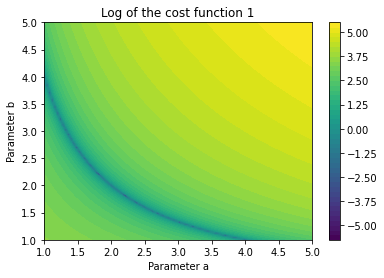

interactive(children=(FloatSlider(value=10.0, description='k', max=10.0, min=0.1, step=1.0), Output()), _dom_c…

<function __main__.function2(k=10.0)>

In [2]:
def comp_I_bin(dXdT):
    '''Computes the identifiability indicator from a given sensitivity matrix'''
    numVars = dXdT.shape[0]
    H = np.zeros((numVars, numVars))
    T = dXdT.shape[1]
    for i in range(0,numVars):
        for j in range(0,numVars):
            H[i,j] = np.nansum(dXdT[i]*dXdT[j])

    lams = np.linalg.eigvals(H)
    if not (np.min(lams) == 0):
        I = np.log10(np.max(lams)/np.min(lams))
    else:
        I = np.nan
    return I

def comp_sensi_vector(funNum=1,k=10, a=2, b=3): 
    w = math.pi*8
    T = 100
    eps = 0.05
    t = np.linspace(0,5,T)
    U = test_fun(a, b, t, funNum, k)
    U_5pc_a = test_fun((1.+eps)*a, b, t, funNum, k)
    U_5pc_b = test_fun(a, (1.+eps) * b, t, funNum, k)
    
    dSdX = np.zeros((2,T))
    if not(np.max(np.abs(U))) == 0.:
        dSdX[0,:] = (U_5pc_a - U)/(eps * math.sqrt(T) * np.max(np.abs(U)))
        dSdX[1,:] = (U_5pc_b - U)/(eps * math.sqrt(T) * np.max(np.abs(U)))

        I = comp_I_bin(dSdX)
    else:
        I = np.nan
    return I


plot_costFun(1, 10)
I = comp_sensi_vector(1)
print("I (f2): {:.02f}".format(I))

def function2(k=10.):
    plot_costFun(2, k)
    I = comp_sensi_vector(2, k)
    print("I (f2): {:.02f}".format(I))
interact(function2, k=(0.1,10.,1.))

As you can see function 1 presents a large value of $I$ which is consistent with the fact that the problem is ill posed. On the contrary, function 2 has a value lower than 2 and the problem is well posed. To better feel the influence of the cost function shape on $I$, you can play with the value of $k$ for function 2.

Indeed, for function 1, the analytical value of $H$ is given as:
\begin{equation}
H = \sum_{s=0}^{T}{t_s^4}
\begin{pmatrix}
b^2 & ab \\
ba & a^2 \\
\end{pmatrix},
\end{equation}
which eigenvalues are respectively $a^2+b^2$ and 0. The value of I will therefore be infinity (except when $a$ is a multiple of $b$ and vice-versa)

Alternatively, for function 2, we have:
\begin{equation}
H = 
\begin{pmatrix}
T & \sum_{s=0}^{T} \frac{t_s^2}{k} \\
\sum_{s=0}^{T} \frac{t_s^2}{k} & \sum_{s=0}^{T} \frac{t_s^4}{k^2} \\
\end{pmatrix},
\end{equation}
which eigenvalues are $\frac{-B \pm \sqrt{B^2 - 4A}}{2}$ where 
\begin{equation}A = T\sum_{s=0}^{T} \frac{t_s^4}{k^2} - \left(\sum_{s=0}^{T} \frac{t_s^2}{k}\right)^2 \quad\quad B = T + \sum_{s=0}^{T} \frac{t_s^4}{k^2},\end{equation}
which yields:
\begin{equation}
I = \frac{-1 + \sqrt{1 - 4\frac{A}{B^2}}}{-1 - \sqrt{1 - 4\frac{A}{B^2}}}
\end{equation}
The value of $I$ is therefore a function of $k$.

## Relation between I and the solution
----

In the analytical solutions for the eigenvalues derived above, you can notice that the searched solution $(a, b)$ appears explicitely. $I$ will therefore vary with the solution found and should also be checked after optimisation.

To illustrate this, the following code plots the variation of $I$ with $(a,b)$ for function 2.

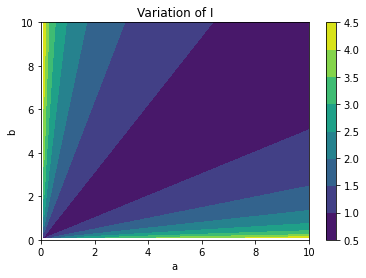

In [29]:
n_p = 100
a = np.linspace(0,10,n_p)
b = np.linspace(0,10,n_p)
A, B = np.meshgrid(a, b)
I = np.zeros((n_p, n_p))

for i in range(0, n_p):
    for j in range(0, n_p):
        I[i, j] = comp_sensi_vector(2, a=A[i, j], b=B[i, j], k=10)

plt.contourf(A, B, I)
plt.xlabel('a')
plt.ylabel('b')
plt.title("Variation of I")
plt.colorbar()
plt.show()
plt.close()

## Colinearity and noise
----

The indicator $I$ mainly gives two important information:
- Is the function sensitive to every parameters with the same strength ?
- Do every parameter have uncorrelated influences on $f$

Indeed, if we look at function $f^1$ defined above, a variation of $5\%$ of $a$ or $b$ would have the exact same effect on function $f$: the sensitivity vectors of these two parameters are collinear. Therefore it would not be possible to differentiate the effect of $a$ or $b$ which is another way to understand why the problem is ill posed.

To undertand the importance of collinearity, let's plot the sensitivity vectors of function $f^1$ in python for a variation of $a$ and $b$ of $5\%$ and take a look at the value of $I$ (do not touch the cursor yet ;)):

In [6]:
def noise(b,t):
    '''Sinusoidal noise of amplitude b and frequency w'''
    return np.random.normal(0., b, len(t))
    
def comp_sensi_noise(noise_amp=0., funNum=1):
    a = 2.
    b = 2.  
    w = math.pi*8
    T = 100
    eps = 0.05
    t = np.linspace(0,5,T)
    U = test_fun(a, b, t, funNum, 10) + noise(noise_amp,t)
    U_5pc = test_fun((1.+eps)*a, b, t, funNum, 10) + noise(noise_amp,t)
    U_5pc_noise = test_fun(a, (1.+eps) * b, t, funNum, 10) + noise(noise_amp,t)

    plt.figure(figsize=(14,6))
    plt.subplot(121)
    plt.title("Function f")
    plt.plot(t, U, label="$f_{a,b}(t)$")
    plt.plot(t, U_5pc, label="$f_{1.05*a,b}(t)$")
    plt.plot(t, U_5pc_noise, label="$f_{a,1.05*b}(t)$")
    plt.xlabel("t")
    plt.ylabel("f(t)")
    plt.legend()

    plt.subplot(122)
    plt.title("Sensitivity variation")
    dSdX = np.zeros((2,T))
    dSdX[0,:] = (U_5pc - U)/(eps * math.sqrt(T) * np.max(U))
    dSdX[1,:] = (U_5pc_noise - U)/(eps * math.sqrt(T) * np.max(U))
    plt.plot(t, dSdX[0], label="$f_{1.05*a,b}(t)$")
    plt.plot(t, dSdX[1], label="$f_{a,1.05*b}(t)$")
    plt.xlabel("t")
    plt.ylabel("$df/d\\theta$")
    plt.legend()
    plt.show()
    
    I = comp_I_bin(dSdX)
    print("Value of I: {:.02f}".format(I))

 
print("Noise amplitude")
interact(comp_sensi_noise, noise_amp=(0.,0.5,0.01), funNum=fixed(1))

plt.close()

Noise amplitude


interactive(children=(FloatSlider(value=0.0, description='noise_amp', max=0.5, step=0.01), Output()), _dom_cla…

As you can see, the sensitivity vectors of the two variables (shown on the right) are exactly the same. This result in a very bad value of $I$ (16.17).

Now, let's push the slider and add some gaussian noise to function $f^1$ ! As you're pushing the slider up, you can see that it artificially decorelates the two sensitivity vectors. Consequently, the noisier, the better the value of $I$

However, this does not mean that the problem becomes well-posed, as our function remains the same. In some cases, numerical noise could happen just because of iteration residuals, interpolation errors, etc... The value of $I$ should therefore always be taken with great care.